# Project 3.1.1 Data Cleaning and Data Science Process - Finalver.
---
Following scraping textual information from reddit posts, we now continue with the data science process of data cleaning, EDA, model building, evaluation and lastly recommendation of business solutions.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

# always be stylish
plt.style.use('ggplot')

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import confusion_matrix

In [2]:
# Read in google home reddit data
df_gh = pd.read_csv('./reddit_gh.csv')
df_gh.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,media,is_video,link_flair_template_id,post_hint,preview,media_metadata,crosspost_parent_list,crosspost_parent,author_cakeday,poll_data
0,NaN,googlehome,[\[FAQ - Frequently Asked Questions\]](https:/...,t2_q648wkk,False,NaN,0,False,FAQ: Please read the subreddit FAQ before post...,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,googlehome,Do you want to liberate your Google so it can ...,t2_8hlsb,False,NaN,0,False,My Google has Coronavirus! - Monthly Rants and...,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,googlehome,Because that's all it is.,t2_1mgxh,False,NaN,0,False,[Subreddit Request] Can we rename this subredd...,[],...,NaN,False,489ab03e-b78e-11e6-8fd6-0e00dc2f4472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,googlehome,NaN,t2_mnm0w,False,NaN,0,False,This one really takes the cake.,[],...,NaN,False,NaN,image,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN
4,NaN,googlehome,NaN,t2_me5yarn,False,NaN,0,False,Where did my routines go to? They're still in ...,[],...,NaN,False,0ab35abe-b78e-11e6-9303-0ed3c72a1f42,image,{'images': [{'source': {'url': 'https://previe...,NaN,NaN,NaN,NaN,NaN


The columns with the more relevant textual data are from subreddit, selftext and title. 

In [3]:
# Set a new dataframe with the columns we want ()
df_gh1 = pd.DataFrame(df_gh[['subreddit', 'selftext', 'title']])
# Shape of dataframe
df_gh1.shape

(996, 3)

In [4]:
# Drop duplicates in selftext column
df_gh1.drop_duplicates(subset='selftext',inplace=True)
# Shape of dataframe after removing duplicates
df_gh1.shape

(825, 3)

In [5]:
# Drop NAs.
df_gh1.dropna(inplace=True)
# Shape of dataframe after removing NAs
df_gh1.shape

(824, 3)

In [6]:
# Review first 5 rows of dataframe
df_gh1.head()

,subreddit,selftext,title
0,googlehome,[\[FAQ - Frequently Asked Questions\]](https:/...,FAQ: Please read the subreddit FAQ before post...
1,googlehome,Do you want to liberate your Google so it can ...,My Google has Coronavirus! - Monthly Rants and...
2,googlehome,Because that's all it is.,[Subreddit Request] Can we rename this subredd...
6,googlehome,So I set an alarm there and Google responded '...,Google just said no problem
7,googlehome,Recently got a Nest WiFi router. I currently l...,Nest WiFi - who can access router settings?


In [7]:
# Read in google pixel reddit data
df_gp = pd.read_csv('./reddit_gp.csv')
df_gp.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,event_start,post_hint,preview,event_end,event_is_live,link_flair_template_id,media_metadata,poll_data,crosspost_parent_list,crosspost_parent
0,NaN,GooglePixel,This is the weekly photo megathread. Photos ca...,t2_6l4z3,False,NaN,0,False,Weekly #madebygoogle Photos Megathread - May 0...,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,GooglePixel,*If you were redirected here from a removed po...,t2_zmjf4,False,NaN,0,False,"The May 2020 Superthread: Pixel 4a, Battery, ""...",[],...,1.588345e+09,self,{'images': [{'source': {'url': 'https://extern...,1.588360e+09,False,NaN,NaN,NaN,NaN,NaN
2,NaN,GooglePixel,It was supposed to take up to 10 days. But it ...,t2_10j65hn2,False,NaN,0,False,"So I had some troubles with my phone, and sent...","[{'e': 'text', 't': 'Pixel 3a'}]",...,NaN,NaN,NaN,NaN,NaN,bd247e74-7476-11e9-b802-0e2121dcd2a2,NaN,NaN,NaN,NaN
3,NaN,GooglePixel,Yall weren't kidding about the battery. It's p...,t2_zfetx,False,NaN,0,False,Had my pixel 4 for a few days already and holy...,"[{'e': 'text', 't': 'Pixel 4'}]",...,NaN,NaN,NaN,NaN,NaN,8697ce76-f2dc-11e9-8412-0eae23347634,NaN,NaN,NaN,NaN
4,NaN,GooglePixel,NaN,t2_bkfyp,False,NaN,0,False,Pixel 3a black screen after overnight charging,"[{'e': 'text', 't': 'Pixel 3a'}]",...,NaN,hosted:video,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,bd247e74-7476-11e9-b802-0e2121dcd2a2,NaN,NaN,NaN,NaN


In [8]:
# Set a new dataframe with the columns we want ()
df_gp1 = pd.DataFrame(df_gp[['subreddit', 'selftext', 'title']])
# Shape of dataframe
df_gp1.shape

(980, 3)

In [9]:
# Drop duplicates in selftext column
df_gp1.drop_duplicates(subset='selftext',inplace=True)
# Shape of dataframe after removing duplicates
df_gp1.shape

(803, 3)

In [10]:
# Drop NAs.
df_gp1.dropna(inplace=True)
# Shape of dataframe after removing NAs
df_gp1.shape

(802, 3)

In [11]:
# Join the two dataframes together
df = pd.concat([df_gh1,df_gp1])
df.reset_index(drop=True, inplace=True)
# Shape of concatenated dataframe 
df.shape

(1626, 3)

In [12]:
df['subreddit'].value_counts()

googlehome     824
GooglePixel    802
Name: subreddit, dtype: int64

In [13]:
# Engineer a feature to turn subreddit into a 1/0 column, where 1 indicates googlehome.
df['googlehome'] = df['subreddit'].map({'googlehome': 1, 'GooglePixel': 0})
df.head(2)

,subreddit,selftext,title,googlehome
0,googlehome,[\[FAQ - Frequently Asked Questions\]](https:/...,FAQ: Please read the subreddit FAQ before post...,1
1,googlehome,Do you want to liberate your Google so it can ...,My Google has Coronavirus! - Monthly Rants and...,1


In [14]:
df['googlehome'].value_counts(normalize=True)

1    0.506765
0    0.493235
Name: googlehome, dtype: float64

The distribution of the classes is quite balanced. If the class is imblanced, the resulting model is likely to have low predictive accuracy for the infrequent class.

### Basic EDA
---
Building good performing classifers from data with easily separable classes is relatively straightforward but care should be excercised to determine if such data is representative of the actual world environment. In most real world environment, samples from different classes share similar characteristics or are overlapped. This means the boundaries of each class may not be clearly defined as desired. 

Common practices to address this problem includes:
- i) modifying the original data by introducing/removing features which decrease the overlapping region,
- ii) adapting algorithms to reduce the negative impact of overlapping features.

Through the basic EDA process, we set out to discover what are the prevalent key words among the reddit posts, and their distribution across text data of googlehome and googlepixel reddit posts. With these insights we would then be in better position to fine-tune the subsequent models.

In [15]:
text = df['selftext']
text[0:5]

0    [\[FAQ - Frequently Asked Questions\]](https:/...
1    Do you want to liberate your Google so it can ...
2                            Because that's all it is.
3    So I set an alarm there and Google responded '...
4    Recently got a Nest WiFi router. I currently l...
Name: selftext, dtype: object

In [16]:
'''
create a document term matrix with:
-ngram range 1,2
-minimum document appearance for any term = 2
-removal of all English stop words
'''
# Instantiate countvectorizer
cvec = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=2)
matrix = cvec.fit_transform(text)

In [17]:
# Create a dataframe with feature names = words
tf = pd.DataFrame(cvec.fit_transform(text).toarray(), columns=cvec.get_feature_names())

In [18]:
# see most common terms
tf.sum().sort_values(ascending=False).head(10)

google         1731
home           1054
pixel           993
phone           882
just            736
google home     606
buds            559
ve              547
like            533
app             429
dtype: int64

In [19]:
# Create googlehome text df
googlehome_tdf = df[df['googlehome'] ==1]
googlehome_tdf.shape
googlehome_tdf.head()

,subreddit,selftext,title,googlehome
0,googlehome,[\[FAQ - Frequently Asked Questions\]](https:/...,FAQ: Please read the subreddit FAQ before post...,1
1,googlehome,Do you want to liberate your Google so it can ...,My Google has Coronavirus! - Monthly Rants and...,1
2,googlehome,Because that's all it is.,[Subreddit Request] Can we rename this subredd...,1
3,googlehome,So I set an alarm there and Google responded '...,Google just said no problem,1
4,googlehome,Recently got a Nest WiFi router. I currently l...,Nest WiFi - who can access router settings?,1


In [20]:
# Create googlepixel text df
googlepixel_tdf = df[df['googlehome'] == 0]
googlepixel_tdf.shape

(802, 4)

In [21]:
# vectorize selftext from googlehome text
tf1 = pd.DataFrame(cvec.fit_transform(googlehome_tdf['selftext']).toarray(), columns=cvec.get_feature_names())

In [22]:
# No.of features fitted
tf1.shape

(824, 4502)

In [23]:
# check value counts
tf1.sum().sort_values(ascending=False).head(10)

google         1260
home            992
google home     600
just            312
play            283
app             265
ve              254
nest            248
set             246
mini            230
dtype: int64

As expected, the words `google`, `home` and `google home` have high prevalence in google home reddit posts.

In [24]:
# vectorize selftext from googlehome text
tf2 = pd.DataFrame(cvec.fit_transform(googlepixel_tdf['selftext']).toarray(), columns=cvec.get_feature_names())

In [25]:
# No.of features fitted
tf2.shape

(802, 5352)

In [26]:
# check value counts
tf2.sum().sort_values(ascending=False).head(10)

pixel         980
phone         672
buds          559
google        471
just          424
like          321
ve            293
pixel buds    265
battery       225
don           208
dtype: int64

The words `google`, `phone` and `pixel` have high prevalence in google pixel reddit posts. Are any of these words common among the two reddit groups, and what is their distribution? Let's find out.

In [27]:
# word counts of googlehome text and google pixel text
"""Merge the two dataframes on Outer join, align with both dataframe indexes."""
word_counts = pd.merge(pd.DataFrame(data=tf1.sum().sort_values(ascending=False)),\
                       pd.DataFrame(data=tf2.sum().sort_values(ascending=False)),\
                       how='outer',left_index=True,right_index=True)
print(word_counts)

              0_x   0_y
00            4.0   2.0
04            NaN   5.0
05            NaN   2.0
09            NaN   2.0
10           38.0  77.0
...           ...   ...
zero issues   NaN   2.0
zoom          NaN  24.0
zoom app      NaN   2.0
zoom video    NaN   2.0
zoomed        NaN   2.0

[8019 rows x 2 columns]


In [28]:
# rename columns
word_counts.columns = ['googlehome', 'googlepixel']

In [29]:
# view the df to ensure correct column naming
word_counts.head(2)

,googlehome,googlepixel
00,4.0,2.0
04,NaN,5.0


In [30]:
# find sums
word_counts['sum'] = word_counts['googlehome'] + word_counts['googlepixel']
# sort by most used values
word_counts.sort_values(['sum'], ascending=False).head(10)

,googlehome,googlepixel,sum
google,1260.0,471.0,1731.0
home,992.0,62.0,1054.0
pixel,13.0,980.0,993.0
phone,210.0,672.0,882.0
just,312.0,424.0,736.0
google home,600.0,6.0,606.0
ve,254.0,293.0,547.0
like,212.0,321.0,533.0
app,265.0,164.0,429.0
use,197.0,177.0,374.0


In [31]:
# Minimum occurrence of words
word_counts.sort_values(['sum'], ascending=True).head(5)

,googlehome,googlepixel,sum
does recognize,2.0,2.0,4.0
google help,2.0,2.0,4.0
just getting,2.0,2.0,4.0
refusing,2.0,2.0,4.0
app issue,2.0,2.0,4.0


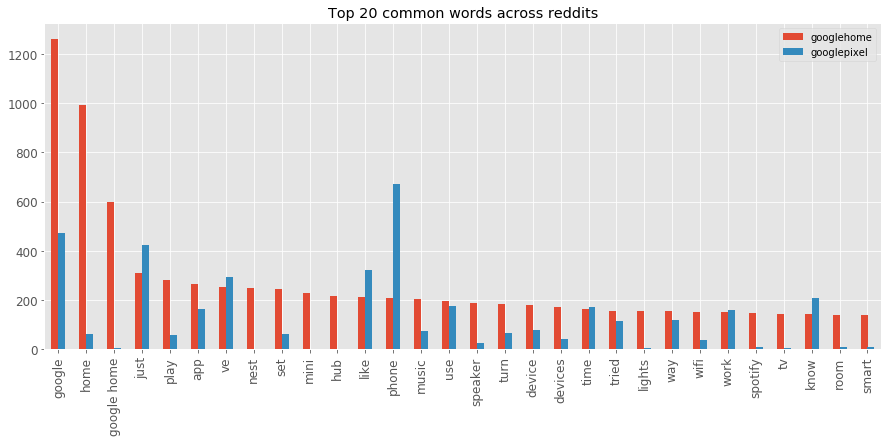

In [32]:
# plot 20 most used words
word_counts.sort_values(['googlehome','googlepixel'], ascending=False).drop('sum', axis=1).head(30).\
plot(kind='bar',figsize=(15,6),fontsize=12,title='Top 20 common words across reddits');

In [33]:
print(f"googlehome total posts: {df_gh1.shape[0]}, word count: {word_counts['googlehome'].sum()}")
print(f"googlepixel total posts: {df_gp1.shape[0]}, word count: {word_counts['googlepixel'].sum()}")

googlehome total posts: 824, word count: 39648.0
googlepixel total posts: 802, word count: 45369.0


While the word `google` is unexpectedly common with 1731 instances, an interestingly observation is that it is not as prevalent for google pixel posts compared to google home. This could be due to consumers referring the google handphone simply as `pixel`. 
For (binary) classification problem, the ideal case is perfect separation in features for the classes. However, this is rarely the case in actual world environment. Observe that there are words that are common between `googlehome` and `googlepixel`. 
We remove words that have two characteristics:
- significant overlaps (smallest difference in word count occurrence in both classes)
- occur frequently. From the plot above, word count occurrence of more than 200 is determined emohirically to be a suitable  measure. 

In [34]:
# find words with 
# 1. significant overlaps
# 2. measure by gap (difference of word count between googlehome & googlepixel class)
# 3. identify the more significant occuring ones by population proportion
word_counts['gap'] = abs(word_counts['googlehome'] - word_counts['googlepixel'])
# sort by most used values
word_counts.sort_values(['gap'], ascending=True).loc[(word_counts['sum']>300) & (word_counts['gap']<50)]

,googlehome,googlepixel,sum,gap
work,150.0,158.0,308.0,8.0
time,164.0,174.0,338.0,10.0
use,197.0,177.0,374.0,20.0
ve,254.0,293.0,547.0,39.0


In [35]:
word_counts.sort_values(['gap'], ascending=True).loc[(word_counts['sum']>200) & (word_counts['gap']<50)]

,googlehome,googlepixel,sum,gap
does,138.0,140.0,278.0,2.0
work,150.0,158.0,308.0,8.0
time,164.0,174.0,338.0,10.0
want,139.0,120.0,259.0,19.0
use,197.0,177.0,374.0,20.0
using,129.0,162.0,291.0,33.0
way,155.0,121.0,276.0,34.0
assistant,138.0,102.0,240.0,36.0
ve,254.0,293.0,547.0,39.0
tried,156.0,116.0,272.0,40.0


The top 10 words commonly overlapping words are [`does`, `work`, `time`, `want`, `use`, `using`, `way`, `assistant`, `ve`, `tried`] are the more common words among the two reddits with significant overlap (similar distribution, with word count aprrox. 200). To measure the impact on model predictive accuracy, it is proposed compare a logreg model without removing these key words and another logreg model with these key words removed.  

### Word Art
---
Following the EDA process, we received a request from the marketing department. They wanted to understand the hot topics for google home and google pixel by inference of the keywords from Reddit posts. While word cloud is technically not data science, we make a small detour to help them out.

In [36]:
# Import libraries
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from matplotlib.pyplot import imread
%matplotlib inline

import numpy as np

In [37]:
# create a list of all the text from googlehome
wa_gh = pd.DataFrame(cvec.fit_transform(googlehome_tdf['selftext']).toarray(), columns=cvec.get_feature_names())
all_textgh = []
for x in wa_gh:
    all_textgh.append(x)

In [38]:
# create a list of all the text from googlepixel
wa_gp = pd.DataFrame(cvec.fit_transform(googlepixel_tdf['selftext']).toarray(), columns=cvec.get_feature_names())
all_textgp = []
for x in wa_gp:
    all_textgp.append(x)

In [39]:
# format it into str
# In Python 3, unicode has been renamed to str.
googlehome_text = str(all_textgh)
googlepixel_text = str(all_textgp)

In [40]:
# Define function to generate wordart (wordcloud)
def cloud(source_text):
    stop_words = ["ve'"] + list(STOPWORDS)
    wordcloud = WordCloud(max_words=200,\
                          stopwords=stop_words,\
                          background_color="black",\
                          min_font_size=10,\
                          colormap='viridis').generate(source_text)
    
    plt.figure(figsize=(9,6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

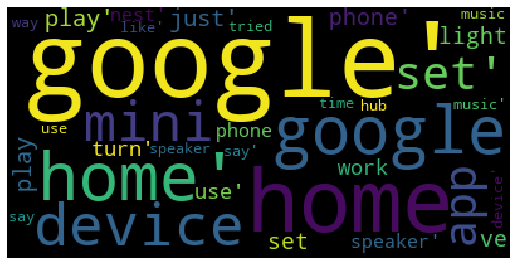

In [41]:
# Generate word cloud image for googlehome
cloud(googlehome_text)

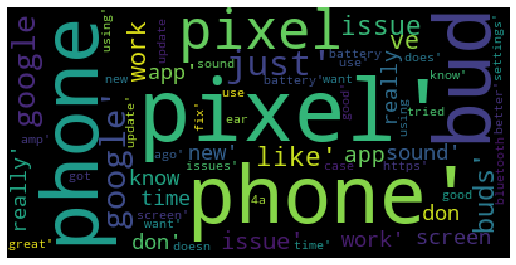

In [42]:
# Generate word cloud image for googlepixel
cloud(googlepixel_text)

### Model Prep
---
In model learning, data is usually segregated into 
- training set; where model learns from the pattern within this set of data,
- validate set; where model or group of models are evaluated. This is the performance the model is expected to have on unseen data.  
- test set; the best performing model is then shortlisted and tested on the test set.

We first split data into i) train and test set, then split the train set into train subsets and validate subsets.

Dataleakage is an issue where a learned model is overfitted on the train data and not generalize well to new, unseen data. This can be mitigated by spliting the data upfront, fitting only on the train set and transform the validate set. This is to prevent data leakage from the validate set to the train set. (Similar principle applies on test set). This also means excercise caution not to inadvertently countvectorize (a transformer) the data first before doing train-test-split.

In [43]:
# Create Train-Test split (80-20 split)
# X is selftext. y is googlehome.
X_train,X_test,y_train,y_test = train_test_split(df[['selftext']],df['googlehome'],test_size=0.20,\
                                                 stratify=df['googlehome'],\
                                                 random_state=42)

In [44]:
# Equal proportion of classes split across train and test set
print(y_train.value_counts())
y_test.value_counts()

1    659
0    641
Name: googlehome, dtype: int64


1    165
0    161
Name: googlehome, dtype: int64

In [63]:
# Create Train-Validate subsets (80-20 split) from the parent Train set
# X is selftext. y is googlehome.
X_trainf,X_validate,y_trainf,y_validate = train_test_split(X_train[['selftext']],y_train,test_size=0.20,\
                                                           stratify=y_train,random_state=42)

In [64]:
# Lines of text in train set, validate set and test set
lines_trainf = X_trainf.shape[0]
lines_validate = X_validate.shape[0]
lines_test = X_test.shape[0]
print(f"Lines in train set: {lines_trainf}.")
print(f"Lines in validate set: {lines_validate}.")
print(f"Lines in test set: {lines_test}.")

Lines in train set: 1040.
Lines in validate set: 260.
Lines in test set: 326.


In [65]:
# Instantiate porterstemmer
p_stemmer = PorterStemmer()

In [66]:
# Define function to convert a raw selftext to a string of words
# The input is a single string (a raw selftext), and 
# the output is a single string (a preprocessed selftext)

def selftext_to_words(raw_selftext):
    
    # 1. Remove HTML.
    selftext_text = BeautifulSoup(raw_selftext).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", selftext_text)
    
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))

    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5.5 Stemming of words
    meaningful_words = [p_stemmer.stem(w) for w in words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result
    return(" ".join(meaningful_words))

In [68]:
#Initialize an empty list to hold the clean reviews.
X_trainf_clean = []
X_validate_clean = []
X_test_clean = []

#For train set
# Instantiate counter.
j = 0
for text in X_trainf['selftext']:
    """Convert text to words, then append to X_trainf_clean."""
    X_trainf_clean.append(selftext_to_words(text))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 1000 == 0:
        print(f'Clean & parse {j + 1} of {lines_trainf+lines_validate+lines_test}.')
    
    j += 1
    
# For validate set
for text in X_validate['selftext']:
    """Convert text to words, then append to X_validate_clean."""
    X_validate_clean.append(selftext_to_words(text))
    
    # If the index is divisible by 1629, print a message.
    if (j + 1) % (lines_train+lines_test) == 0:
        print(f'Clean and parse {j + 1} of {lines_train+lines_test}.')
    
    j += 1
    
# For test set
for text in X_test['selftext']:
    """Convert text to words, then append to X_test_clean."""
    X_test_clean.append(selftext_to_words(text))
    
    # If the index is divisible by 1629, print a message.
    if (j + 1) % (lines_trainf+lines_validate+lines_test) == 0:
        print(f'Clean and parse {j + 1} of {lines_trainf+lines_validate+lines_test}.')
    
    j += 1

Clean & parse 1000 of 1626.
Clean and parse 1626 of 1626.


### Baseline accuracy
---
We first derive the baseline accuracy so as to be able to determine if the subsequent models are better than the baseline (null) model (predicting the plurality class).

In [69]:
y_test.value_counts(normalize=True)

1    0.506135
0    0.493865
Name: googlehome, dtype: float64

The Baseline accuracy is the percentage of the majority class. In this case, the baseline accuracy is 0.506135. 
This serves as benchmark for measuring model performance (i.e. model accuracy should be higher than this baseline).

### Logistic Regression Model
---
For this project, Logistic Regression and Naive Bayes models are explored. Logistic Regression models are examined in this section.

In [74]:
# Set up a pipeline with two stages
# 1.CountVectorizer (transformer)
# 2.LogisticRegression (estimator)
pipe1 = Pipeline([('cvec',CountVectorizer()),\
                 ('logreg',LogisticRegression(solver='lbfgs',max_iter=200,random_state=42))\
                ])

In [75]:
# Parameters of pipeline object
pipe1.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('logreg',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=200,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'cvec': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='cont

In [76]:
# Load pipeline object into GridSearchCV to tune CountVectorizer
# Search over the following values of hyperparameters:
# Maximum number of features fit (top no. frequent occur words): 2000, 3000, 4000, 5000
# Minimum number of documents (collection of text) needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

# n-gram: 1 token, 1-gram, or 1 token, 2-gram.
pipe_params = {
    'cvec__max_features': [2_000,3_000,4_000,5_000],\
    'cvec__min_df': [2,3],\
    'cvec__max_df': [0.9,0.95],\
    'cvec__ngram_range': [(1, 1), (1,2)]\
}

In [77]:
# Instantiate GridSearchCV.
"""pipe refers to the object to optimize."""
"""param_grid refer to parameter values to search."""
"""cv refers to number of cross-validate fold."""
gs1 = GridSearchCV(pipe1,\
                  param_grid=pipe_params,\
                  cv=10)

In [80]:
# Fit GridSearch to the cleaned training data.
gs1.fit(X_trainf_clean,y_trainf)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        pre

In [81]:
# Check the results of the grid search

print(f"Best parameters: {gs1.best_params_}")
print(f"Best score: {gs1.best_score_}")

Best parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}
Best score: 0.9307692307692308


In [84]:
# Save best model as gs_model.

gs1_model = gs1.best_estimator_

In [103]:
# Score model on training set & testing set
print(f"Accuracy on train set: {gs1_model.score(X_trainf_clean, y_trainf)}")
print(f"Accuracy on validate set: {gs1_model.score(X_validate_clean, y_validate)}")

Accuracy on train set: 0.9980769230769231
Accuracy on validate set: 0.9307692307692308


The model accuracy is higher than the baseline accuracy (0.506). However, the model is overfitted with about 7% drop in test accuracy compared to train accuracy.

In [86]:
# Confusion matrix on the first log reg model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is googlehome
preds = gs1.predict(X_test_clean)
cm = confusion_matrix(y_test, preds)
cm_df = pd.DataFrame(cm,columns=['pred googlepixel','pred googlehome'], index=['Actual googlepixel','Actual googlehome'])
cm_df

,pred googlepixel,pred googlehome
Actual googlepixel,146,15
Actual googlehome,14,151


The positive class (class 1) refers to `googlehome`. False positive means the observation is classified as `googlehome` when it is actually `googlepixel`. 
False negative means the ovservation is classified as `googlepixel` when it is actually `googlehome`.

In [87]:
# return nparray as a 1-D array.
confusion_matrix(y_test, preds).ravel()
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test,preds).ravel()

In [90]:
# Summary of metrics for first log reg model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")
print(f"Accuracy: {round(gs1.score(X_validate_clean,y_validate),4)}")

Specificity: 0.9068
Sensitivity: 0.9152
Accuracy: 0.9308


The Receiver Operating Characteristic curve is a way to visualize the overlap between our positive class and negative class by moving our classification threshold from 0 to 1. 

The ROC curve shows the trade-off between sensitivity (or TruePositiveRate) and specificity (1 – FalsePositiveRate). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a no-skill classifier is expected to give points lying along the diagonal (FPRate = TPRate). The closer the curve is to the diagonal line, the less accurate the classifier is. 

Hence, the more area under the blue curve, the better separated the class distributions are. The best trade-off between sensitivity and specificity is the top-left point along the ROC curve.

In [92]:
# To visualize the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our validate set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gs1.predict_proba(X_validate_clean)]

pred_df = pd.DataFrame({'validate_values': y_validate,
                        'pred_probs':pred_proba})
pred_df.head()

,validate_values,pred_probs
1445,0,3.905379e-02
1152,0,1.932087e-09
216,1,4.094079e-01
1001,0,4.466822e-06
1120,0,2.030855e-03


In [93]:
# Import roc_auc_score.
from sklearn.metrics import roc_auc_score

In [94]:
# Calculate ROC AUC.
roc_auc_score(pred_df['validate_values'],pred_df['pred_probs'])

0.9909741950757576

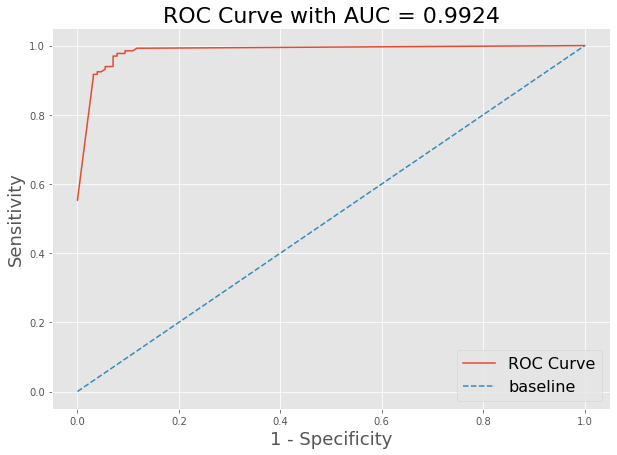

In [155]:
#Create figure
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed orange line in plot.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["validate_values"], pred_df["pred_probs"]),4)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

An ROC AUC of 1 means the positive and negative populations are perfectly separated and that the model is as good as it can get. The closer the ROC AUC is to 1, the better. (1 is the maximum score.)

What would be the impact on model accuracy with the removal of the discovered overlapping key words? Let's find out.

In [96]:
# Set up a pipeline, pipe2 with two stages
# 1.CountVectorizer (transformer)
# 2.LogisticRegression (estimator)
# 3.Remove the words ['does', 'work', 'time', 'want', 'use', 'using', 'way', 'assistant', 've', 'tried'] 
# via CountVectorizer
pipe2 = Pipeline([('cvec',CountVectorizer(stop_words=['does', 'work', 'time', 'want', 'use',\
                                                      'using', 'way', 'assistant', 've', 'tried'])),\
                  ('logreg',LogisticRegression(solver='lbfgs',max_iter=200,random_state=42))\
                 ])

In [97]:
# Parameters of pipeline object
pipe2.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None,
                   stop_words=['does', 'work', 'time', 'want', 'use', 'using',
                               'way', 'assistant', 've', 'tried'],
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('logreg',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=200,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'cvec': CountVectorizer(

In [98]:
# Load pipeline object into GridSearchCV to tune CountVectorizer
# Search over the following values of hyperparameters:
# Maximum number of features fit (top no. frequent occur words): 2000, 3000, 4000, 5000
# Minimum number of documents (collection of text) needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

# n-gram: 1 token, 1-gram, or 1 token, 2-gram.
pipe2_params = {
    'cvec__max_features': [2_000,3_000,4_000,5_000],\
    'cvec__min_df': [2,3],\
    'cvec__max_df': [0.9,0.95],\
    'cvec__ngram_range': [(1, 1), (1,2)]\
}

In [99]:
# Instantiate GridSearchCV.
"""pipe refers to the object to optimize."""
"""param_grid refer to parameter values to search."""
"""cv refers to number of cross-validate fold."""
gs2 = GridSearchCV(pipe2,\
                  param_grid=pipe2_params,\
                  cv=10)

In [100]:
# Fit GridSearch to the cleaned training data.
gs2.fit(X_trainf_clean,y_trainf)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        pre

In [101]:
# Check the results of the grid search

print(f"Best parameters: {gs2.best_params_}")
print(f"Best score: {gs2.best_score_}")

Best parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}
Best score: 0.9336538461538462


In [102]:
# Save best model as gs_model.

gs2_model = gs2.best_estimator_

In [104]:
# Score model on training set & testing set
print(f"Accuracy on train set: {gs2_model.score(X_trainf_clean, y_trainf)}")
print(f"Accuracy on validate set: {gs2_model.score(X_validate_clean, y_validate)}")

Accuracy on train set: 0.9990384615384615
Accuracy on validate set: 0.9346153846153846


The removal of the identified key words has a slight improvment to accuracy score on validate set.

In [105]:
# Confusion matrix on the second log reg model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is googlehome
preds2 = gs2.predict(X_validate_clean)
cm = confusion_matrix(y_validate, preds2)
cm_df = pd.DataFrame(cm,columns=['pred googlepixel','pred googlehome'], index=['Actual googlepixel','Actual googlehome'])
cm_df

,pred googlepixel,pred googlehome
Actual googlepixel,121,7
Actual googlehome,10,122


Compared to the first logistic regression model. Not surprisingly, the number of False positive/ False negatives increased with the slight decreased in test accuracy, 

In [107]:
# return nparray as a 1-D array.
confusion_matrix(y_validate, preds2).ravel()
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_validate,preds2).ravel()

In [108]:
# Summary of metrics for second log reg model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")
print(f"Accuracy: {round(gs2.score(X_validate_clean,y_validate),4)}")

Specificity: 0.9453
Sensitivity: 0.9242
Accuracy: 0.9346


Compared to the first logistic regression model, the second logistic regression model has higher specificity (True Negative Rate) and sensitivity (True Positive Rate). Overall accuracy as reported is also higher.

In [111]:
# To visualize the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our validate set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gs2.predict_proba(X_validate_clean)]

pred_df = pd.DataFrame({'validate_values': y_validate,
                        'pred_probs':pred_proba})
pred_df.head()

,validate_values,pred_probs
1445,0,2.744111e-01
1152,0,3.377627e-09
216,1,4.924773e-01
1001,0,9.500101e-06
1120,0,4.137363e-03


In [112]:
# Calculate ROC AUC.
roc_auc_score(pred_df['validate_values'],pred_df['pred_probs'])

0.990915009469697

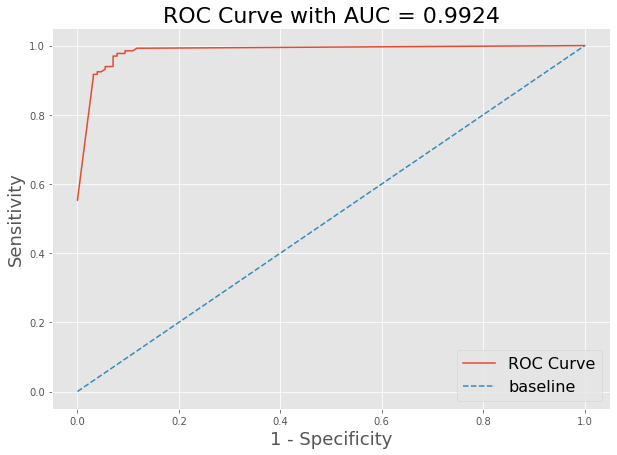

In [160]:
#Create figure
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed orange line in plot.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["validate_values"], pred_df["pred_probs"]),4)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

We see that effect in removal of the identified common overlapping words has minimal effect on boosting the roc_auc.

### Naive Bayes Model
---
We explore the Naive Bayes Model, and apply the removal of identifed common overlapped words identified earlier. First the NB model without removing the identified words.

In [138]:
# Set up a pipeline, p3 with two stages
# 1.CountVectorizer (transformer)
# 2.Naive Bayes(multinomial) (estimator)
pipe3 = Pipeline([('cvec',CountVectorizer()),\
                  ('nb',MultinomialNB())\
                ])

In [139]:
# Parameters of pipeline object
pipe3.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
 'verbose': False,
 'cvec': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 'nb': M

In [140]:
# Load pipeline object into GridSearchCV to tune CountVectorizer
# Search over the following values of hyperparameters:
# Maximum number of features fit (top no. frequent occur words): 2000, 3000, 4000, 5000
# Minimum number of documents (collection of text) needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

# n-gram: 1 token, 1-gram, or 1 token, 2-gram.
pipe_params = {
    'cvec__max_features': [2_000,3_000,4_000,5_000],\
    'cvec__min_df': [2,3],\
    'cvec__max_df': [0.9,0.95],\
    'cvec__ngram_range': [(1, 1), (1,2)]\
}

In [141]:
# Instantiate GridSearchCV.
"""pipe refers to the object to optimize."""
"""param_grid refer to parameter values to search."""
"""cv refers to number of cross-validate fold."""
gs3 = GridSearchCV(pipe3,\
                  param_grid=pipe_params,\
                  cv=10)

In [142]:
# Fit GridSearch to the cleaned training data.
gs3.fit(X_trainf_clean,y_trainf)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        pre

In [143]:
# Check the results of the grid search

print(f"Best parameters: {gs3.best_params_}")
print(f"Best score: {gs3.best_score_}")

Best parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}
Best score: 0.9442307692307692


In [144]:
# Save best model as gs_model.

gs3_model = gs3.best_estimator_

In [145]:
# Score model on training set & testing set
print(f"Accuracy on train set: {gs3_model.score(X_trainf_clean, y_trainf)}")
print(f"Accuracy on validate set: {gs3_model.score(X_validate_clean, y_validate)}")

Accuracy on train set: 0.9701923076923077
Accuracy on validate set: 0.9423076923076923


The naive bayes validate accuracy is higher than the train accuracy, so the model doesn't appear to be overfitted on the training data.
Compared to the logistic regression models, naive bayes model has:
- lower accuracy on train set
- higher accuracy on test set.

We review the sensitivity and specificity, and roc_auc scores before concluding which of the models is the better performing one.

In [146]:
# Confusion matrix on the first naive bayes model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is googlehome
preds3 = gs3.predict(X_validate_clean)
cm = confusion_matrix(y_validate, preds3)
cm_df = pd.DataFrame(cm,columns=['pred googlepixel','pred googlehome'], index=['Actual googlepixel','Actual googlehome'])
cm_df

,pred googlepixel,pred googlehome
Actual googlepixel,116,12
Actual googlehome,3,129


With a higher test accuracy, there is an overall lower number of False positive/ False negatives in validate prediction for Bayes model, compared to logistic regression model. 

In [147]:
# return nparray as a 1-D array.
confusion_matrix(y_validate, preds3).ravel()
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_validate,preds3).ravel()

In [148]:
# Summary of metrics for first naive bayes model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")
print(f"Accuracy: {round(gs3.score(X_validate_clean,y_validate),4)}")

Specificity: 0.9062
Sensitivity: 0.9773
Accuracy: 0.9423


In [149]:
# To visualize the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gs3.predict_proba(X_validate_clean)]

pred_df = pd.DataFrame({'validate_values': y_validate,
                        'pred_probs':pred_proba})
pred_df.head()

,validate_values,pred_probs
1445,0,3.253193e-13
1152,0,9.396531e-28
216,1,9.662100e-01
1001,0,1.550664e-22
1120,0,7.710370e-12


In [161]:
# Calculate ROC AUC.
roc_auc_score(pred_df['validate_values'],pred_df['pred_probs'])

0.9923946496212122

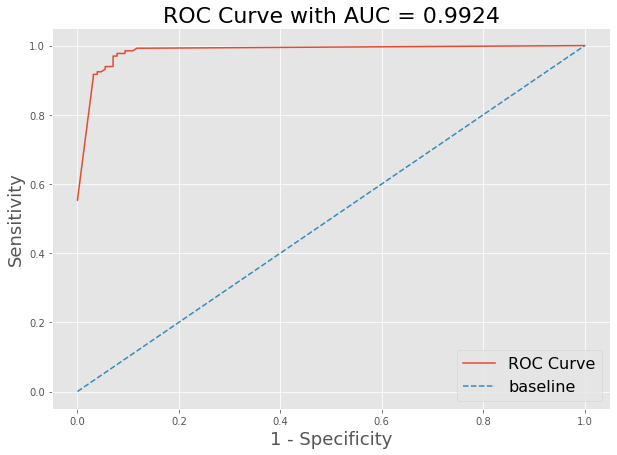

In [163]:
#Create figure
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed blue line in plot.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["validate_values"], pred_df["pred_probs"]),4)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

The roc_auc of the Naive Bayes model is similar to that of the logistic regression models.

Now examine the NB model with identified words ['does', 'work', 'time', 'want', 'use', 'using', 'way', 'assistant', 've', 'tried'] removed.

In [168]:
# Set up a pipeline, p4 with two stages
# 1.CountVectorizer (transformer)
# 2.Naive Bayes(multinomial) (estimator)
# 3.Remove the words ['does', 'work', 'time', 'want', 'use', 'using', 'way', 'assistant', 've', 'tried']

pipe4 = Pipeline([('cvec',CountVectorizer(['does', 'work', 'time', 'want', 'use',\
                                           'using', 'way', 'assistant', 've', 'tried'])),\
                  ('nb',MultinomialNB())\
                ])

In [169]:
# Parameters of pipeline object
pipe4.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8',
                   input=['does', 'work', 'time', 'want', 'use', 'using', 'way',
                          'assistant', 've', 'tried'],
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
 'verbose': False,
 'cvec': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                 input=['does', 'work', 'time', 'want', 'use', 'using', 'way',
                        'assistant', 've', 'tried'],
                 lowercase=True, max_df=1.0,

In [170]:
# Load pipeline object into GridSearchCV to tune CountVectorizer
# Search over the following values of hyperparameters:
# Maximum number of features fit (top no. frequent occur words): 2000, 3000, 4000, 5000
# Minimum number of documents (collection of text) needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

# n-gram: 1 token, 1-gram, or 1 token, 2-gram.
pipe_params = {
    'cvec__max_features': [2_000,3_000,4_000,5_000],\
    'cvec__min_df': [2,3],\
    'cvec__max_df': [0.9,0.95],\
    'cvec__ngram_range': [(1, 1), (1,2)]\
}

In [171]:
# Instantiate GridSearchCV.
"""pipe refers to the object to optimize."""
"""param_grid refer to parameter values to search."""
"""cv refers to number of cross-validate fold."""
gs4 = GridSearchCV(pipe4,\
                  param_grid=pipe_params,\
                  cv=10)

In [172]:
# Fit GridSearch to the cleaned training data.
gs4.fit(X_trainf_clean,y_trainf)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input=['does', 'work',
                                                               'time', 'want',
                                                               'use', 'using',
                                                               'way',
                                                               'assistant',
                                                               've', 'tried'],
                           

In [173]:
# Check the results of the grid search

print(f"Best parameters: {gs4.best_params_}")
print(f"Best score: {gs4.best_score_}")

Best parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}
Best score: 0.9442307692307692


In [174]:
# Save best model as gs_model.

gs4_model = gs4.best_estimator_

In [175]:
# Score model on training set & testing set
print(f"Accuracy on train set: {gs4_model.score(X_trainf_clean, y_trainf)}")
print(f"Accuracy on validate set: {gs4_model.score(X_validate_clean, y_validate)}")

Accuracy on train set: 0.9701923076923077
Accuracy on validate set: 0.9423076923076923


Removal of the identified words for the naive bayes model has not impact on the train and validate accuracies.

We review the sensitivity and specificity, and roc_auc scores before concluding which of the models is the better performing one.

In [176]:
# Confusion matrix on the first naive bayes model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is googlehome
preds4 = gs4.predict(X_validate_clean)
cm = confusion_matrix(y_validate, preds4)
cm_df = pd.DataFrame(cm,columns=['pred googlepixel','pred googlehome'], index=['Actual googlepixel','Actual googlehome'])
cm_df

,pred googlepixel,pred googlehome
Actual googlepixel,116,12
Actual googlehome,3,129


With a higher test accuracy, there is an overall lower number of False positive/ False negatives in validate prediction for Bayes model, compared to logistic regression model. 

In [177]:
# return nparray as a 1-D array.
confusion_matrix(y_validate, preds4).ravel()
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_validate,preds4).ravel()

In [178]:
# Summary of metrics for first naive bayes model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")
print(f"Accuracy: {round(gs4.score(X_validate_clean,y_validate),4)}")

Specificity: 0.9062
Sensitivity: 0.9773
Accuracy: 0.9423


In [179]:
# To visualize the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gs4.predict_proba(X_validate_clean)]

pred_df = pd.DataFrame({'validate_values': y_validate,
                        'pred_probs':pred_proba})
pred_df.head()

,validate_values,pred_probs
1445,0,3.253193e-13
1152,0,9.396531e-28
216,1,9.662100e-01
1001,0,1.550664e-22
1120,0,7.710370e-12


In [180]:
# Calculate ROC AUC.
roc_auc_score(pred_df['validate_values'],pred_df['pred_probs'])

0.9923946496212122

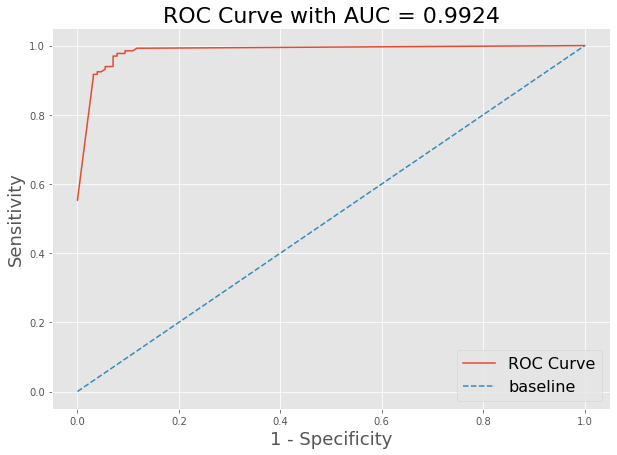

In [181]:
#Create figure
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed blue line in plot.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["validate_values"], pred_df["pred_probs"]),4)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [182]:
# Summary of Model scores in Dataframe
summary_df = pd.DataFrame({'accuracy' : [0.9308, 0.9346, 0.9423, 0.9423],
                          'specificity' : [0.9068, 0.9453, 0.9062, 0.9062],
                          'sensitivity' : [0.9152, 0.9242, 0.9773, 0.9773],
                          'roc_auc' : [0.9924, 0.9924, 0.9924, 0.9924]})
# Transpose dataframe
summary_dft = summary_df.T
# Rename columns
summary_dft.columns = ['LogReg','LogReg(words_rmvd)', 'NB', 'NB(words_rmvd)']
summary_dft

,LogReg,LogReg(words_rmvd),NB,NB(words_rmvd)
accuracy,0.9308,0.9346,0.9423,0.9423
specificity,0.9068,0.9453,0.9062,0.9062
sensitivity,0.9152,0.9242,0.9773,0.9773
roc_auc,0.9924,0.9924,0.9924,0.9924


The team prioritization is on correct classification of Google Home posts as google home devices holds the greater proportion of Google IoT devices. In this regard, we pick model with higher True Positive Rate (sensitivity), for as much correct classification of google home posts as possible. Since both NB and NB(words_rmvd) model have equivalent performance, we pick the NB model as the production model.

Deeper Look at the Production (Naive Bayes) Model 
---
For the test accuracy and roc_auc scores, the Naive Bayes is selected as the better performing model. This section examines 
- model performance on test data
- the features that helps with negative (googlepixel) and positive (googlehome) classifications,
- what could be the features that lead to misclassifications.

In [184]:
# Review model coefficients to see which word is helping with negative / positive classifications)
# As GridSearchCV' object has no attribute 'feature_log_prob_,
# Build separate naive bayes model to enable model coefficient extraction
# using best parameters discovered above in gs3

# Instantiate our CountVectorizer
cv = CountVectorizer(ngram_range=(1,2),max_df=0.9,min_df=3,max_features=4000)

# Fit and transform training data
X_trainf_cleancv = cv.fit_transform(X_trainf_clean)

# Transform test data
X_test_cleancv = cv.transform(X_test_clean)

In [185]:
# Instantiate model
nb = MultinomialNB()

# Fit model
model = nb.fit(X_trainf_cleancv,y_trainf)

# Generate predictions from test set
predictions = nb.predict(X_test_cleancv)

In [187]:
print(f"Accuracy on test set: {model.score(X_test_cleancv, y_test)}")

Accuracy on test set: 0.9386503067484663


In [232]:
# Confusion matrix for test set using NB model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is googlehome
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm,columns=['pred googlepixel','pred googlehome'], index=['Actual googlepixel','Actual googlehome'])
cm_df

,pred googlepixel,pred googlehome
Actual googlepixel,150,11
Actual googlehome,9,156


In [233]:
# return nparray as a 1-D array.
confusion_matrix(y_test, predictions).ravel()
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [234]:
# Summary of metrics for first naive bayes model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")

Specificity: 0.9317
Sensitivity: 0.9455


In [236]:
# To visualize the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in nb.predict_proba(X_test_cleancv)]

pred_df = pd.DataFrame({'test_values': y_test,
                        'pred_probs':pred_proba})

In [237]:
# Calculate ROC AUC.
roc_auc_score(pred_df['test_values'],pred_df['pred_probs'])

0.9806135893092415

In [238]:
# Summary of NB Model scores in Dataframe
summary_df = pd.DataFrame({'accuracy' : [0.9423, 0.9387],
                          'specificity' : [0.9062, 0.9317],
                          'sensitivity' : [0.9773, 0.9455],
                          'roc_auc' : [0.9924, 0.9806]})
# Transpose dataframe
summary_dft = summary_df.T
# Rename columns
summary_dft.columns = ['Validate set','Test set']
summary_dft

,Validate set,Test set
accuracy,0.9423,0.9387
specificity,0.9062,0.9317
sensitivity,0.9773,0.9455
roc_auc,0.9924,0.9806


Slight drop in the model scores for the test set. Model is not overfitted.

In [188]:
import numpy as np
#prob for positive class
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()
#prob for negative class
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
#getting the top features 
pos_top_features = np.take(cv.get_feature_names(), pos_class_prob_sorted)
neg_top_features = np.take(cv.get_feature_names(), neg_class_prob_sorted)


In [189]:
# List of top 30 words that helps in 'googlehome' (positive) classification
print(pos_top_features[:30])

['for what' 'bother' 'love my' 'both bud' 'love them' 'bose' 'bootload'
 'true' 'bluetooth devic' 'quick set' 'macbook' 'mail' 'truli wireless'
 'bike' 'right bud' 'other headphon' 'twitter' 'in ear' 'ubreakifix'
 'right ear' 'system updat' 'freez' 'these bud' 'mask' 'right earbud'
 'becaus the' 'master slave' 'swipe' 'right one' 'surfac']


In [190]:
# List of top 30 words that helps in 'googlepixel' (negative) classification
print(neg_top_features[:30])

['someth went' 'light to' 'the nest' 'command that' 'the network'
 'command or' 'the news' 'command it' 'command for' 'command can'
 'light strip' 'com googlehom' 'off light' 'light bulb' 'have two'
 'chromecast audio' 'chromecast and' 'chromecast' 'can control'
 'thermostat' 'can set' 'lamp' 'can think' 'anoth room' 'have nest'
 'cast from' 'cast to' 'insignia' 'on light' 'video call']


Surprisingly, the top 30 words that aided in postive/ negative classifications are neither `google home` nor `google pixel`. 

**Googlehome**: For positive class (googlehome), it could be inferred that words relevant to IoT device connectivity and interoperability played a part in assisting with classification. Examples of such words include `bose`, `bluetooth devic`, `master slav`. It is noted that word related to `bud` is likely referring to the Google pixel bud (wireless in-ear headphone designed for the google pixel.) Further analysis could be done to determine the reason why these buds are featured within google home posts.

**Googlepixel**: For negative class (googlepixel), interestingly, words more associated with IoT device hubs such as `the nest`, `the network`, `chromecast` actually featured in googlepixel posts. It is a fact that 
- the Nest speakers and displays, Pixel phones, and Chromecast-connected TVs work together to form interconnected audio entertainment systems,
- Audio can be casted from Pixel phones, once they are on the same Wi-Fi network as the Chromecast Audio devices.

The team could review the posts with such words to detemrine if there are actual user pain points for product improvements.

**Reviewing the misclassified samples**: What could be the features that lead to misclassifications?

In [194]:
y_test

919     0
1029    0
764     1
962     0
1064    0
       ..
984     0
362     1
503     1
424     1
1283    0
Name: googlehome, Length: 326, dtype: int64

In [195]:
X_test

,selftext
919,"So I bought pixel 4 after my phone died, and I..."
1029,"Hello, I have a Pixel XL the last time I used ..."
764,But make sure no kids are around\n\nhttps://ph...
962,I've had my P3aXL since launch. Still haven't ...
1064,I had a voicemail with case ID and the number ...
...,...
984,Sorry if this is a basic question but I really...
362,I saw awhile ago that Lenovo was making ambien...
503,I’m extremely rude to my google home... like: ...
424,The study aims to understand how various house...


In [198]:
# Pass y_test (pandas series) into dataframe first
# in order to use the original selftext indexes for traceability
actual = pd.Series(y_test)
df_rvw = actual.to_frame()

# Create column of predicted classes from Naive Bayes model

df_rvw['pred'] = predictions
# Include the selftext data
df_rvw['selftext'] = X_test_clean

# Review the dataframe
df_rvw.head()

,googlehome,pred,selftext
919,0,0,so i bought pixel after my phone die and i m s...
1029,0,0,hello i have a pixel xl the last time i use it...
764,1,0,but make sure no kid are around http photo app...
962,0,0,i ve had my p axl sinc launch still haven t go...
1064,0,0,i had a voicemail with case id and the number ...


In [199]:
# Index of misclassified classes
row_ids = df_rvw[df_rvw['googlehome'] != df_rvw['pred']].index
row_ids

Int64Index([ 764,  525, 1571,  108,  594, 1139,  469, 1498,    2,  749, 1215,
            1024,  888, 1316,  864,  276, 1196,  922, 1132,  117],
           dtype='int64')

In [200]:
# Create overview of the misclassified samples
for i in row_ids:
    print(df_rvw.loc[i])

googlehome                                                    1
pred                                                          0
selftext      but make sure no kid are around http photo app...
Name: 764, dtype: object
googlehome                                                    1
pred                                                          0
selftext      anyon have similar issu sinc lastest updat and...
Name: 525, dtype: object
googlehome                                                    0
pred                                                          1
selftext      okay friend my googl assist ha stop talk to me...
Name: 1571, dtype: object
googlehome                                                    1
pred                                                          0
selftext      the product page onli say w power adaptor dc p...
Name: 108, dtype: object
googlehome                                                    1
pred                                                          0
sel

Two samples from each of misclassified samples are examined in further detail in this section.

**False Negative**: Predicted as googlepixel post but is actually googlehome post. 
To gain insights into what are the words that caused this post to be misclassified as google pixel post, one approach is to compare the words with the list of words that are strongly associated with the negative class. 

Theorectically, all the posts should be reviewed to better identify the 'culprit' words with strong influence on misclassification. We pick one sample from each of the misclassified examples to illustrate the approach. 

We'll start with the false negative sample.

In [205]:
# Index 108 is a false negative
print(df_rvw['selftext'][108])

the product page onli say w power adaptor dc power jack there are no replac cord on the googl store and i can t get through to support i m fine with get a third parti adapt but i m afraid i ll buy someth that either doesn t work with the nest mini or will somehow fri it ha anyon els had to replac the cord if i get an adapt that is more than w is that a problem or is w just a minimum ani help would be appreci


In [222]:
# split the string of text into list of individual words
review1 = df_rvw['selftext'][108].split() 

In [221]:
# Convert numpy array of words stongly associated with googlepixel post into a list
neg_list = neg_top_features.tolist()

In [230]:
# Return the words that likely contributed to false negative classification.
set(review1) & set (neg_list)

{'adapt',
 'an',
 'and',
 'ani',
 'anyon',
 'appreci',
 'are',
 'be',
 'but',
 'buy',
 'can',
 'cord',
 'doesn',
 'either',
 'els',
 'fine',
 'get',
 'googl',
 'ha',
 'had',
 'help',
 'if',
 'is',
 'it',
 'jack',
 'just',
 'll',
 'mini',
 'more',
 'nest',
 'no',
 'on',
 'onli',
 'or',
 'page',
 'parti',
 'power',
 'problem',
 'product',
 'replac',
 'say',
 'somehow',
 'someth',
 'store',
 'support',
 'than',
 'that',
 'the',
 'there',
 'third',
 'through',
 'to',
 'will',
 'with',
 'work',
 'would'}

**False Positive**: Predicted as googlehome post but is actually googlepixel post. 

In [227]:
# Index 1139 is a false positive.
# split the string of text into list of individual words.
print(df_rvw['selftext'][1139])

all of a sudden my bottom speaker stop work onli the top speaker work now and i can t seem to take call on speaker i haven t drop it or anyth i even restart to see if it get fix nada still broken anybodi have a clue what it s about or should i send it to googl for repair


In [228]:
# split the string of text into list of individual words
review2 = df_rvw['selftext'][1139].split() 

In [229]:
# Convert numpy array of words stongly associated with googlehome post into a list
pos_list = pos_top_features.tolist()

In [231]:
# Return the words that likely contributed to false positive classification.
set(review2) & set (pos_list)

{'about',
 'all',
 'and',
 'anybodi',
 'anyth',
 'bottom',
 'broken',
 'call',
 'can',
 'drop',
 'even',
 'fix',
 'for',
 'get',
 'googl',
 'have',
 'haven',
 'if',
 'it',
 'my',
 'now',
 'of',
 'on',
 'onli',
 'or',
 'repair',
 'restart',
 'see',
 'seem',
 'send',
 'should',
 'speaker',
 'still',
 'stop',
 'sudden',
 'take',
 'the',
 'to',
 'top',
 'what',
 'work'}

### Recommendations and Way Forward
---
Naive Bayes model is selected as the production model for classification of googlehome and googlepixel reddit posts. With this model, the team can proceed to with the classification of posts.

To further enhance classification accuracies, we could further review the words that contributed to false positives and false negatives, and remove these words through count vectorizer. Further tuning of the model could continue with the incoming new data.
